<a href="https://colab.research.google.com/github/amandafriedmann/NEUR-Data-Analysis/blob/main/03_29_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cross-Frequency Coupling

Phase coherence is one way of examining how two simultaneously-recorded signals might interact with each other. Specifically, phase coherence assesses the degree to which two oscillations *within the same frequency band* might co-vary over time. We saw, however, when using the Fourier transform to de-construct our complex signals, that real LFP and EEG signals contain oscillations in many different frequency bands. Do these different frequency bands ever interact with each other?

##By the end of this notebook, you will be able to:

- Extract the phase of an oscillation using the **Hilbert transform**
- Extract the amplitude of another oscillation using the same method
- Calculate the relationship between phase and amplitude
- Plot your data

##Background

In this notebook, we focus on local field potential (LFP) recordings. The LFP is a measure of local population neural activity, produced from small aggregates of neurons. In these data, we examine the association between rhythms of different frequencies.

In general, lower-frequency rhythms have been observed to engage larger brain areas and modulate spatially localized fast oscillations [(see, for example)]('https://pubmed.ncbi.nlm.nih.gov/18388295/'). Of the different types of cross-frequency coupling (CFC) observced between brain rhythms, perhaps the most is phase-amplitude coupling (PAC), in which the phase of a low frequency rhythm modulates the amplitude (or power) of a high frequency rhythm. Cross-frequency coupling been observed in many brain regions, has been shown to change in time with task demands, and has been proposed to serve a [functional role]('https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3359652/') in working memory, neuronal computation, communication, and learning. Although the cellular and dynamic mechanisms of specific rhythms associated with CFC are relatively well understood, the mechanisms governing interactions between different frequency rhythms - and the appropriate techniques for measuring CFC - remain active research areas. Although we consider only a single electrode recording here, we note that these techniques can be extended to association measures between electrodes as well.



##Case Study Data

The LFP data we'll be using were recorded from electrodes in the rat hippocampus. These electrodes remain (chronically) implanted as the rat explores a large circular arena. We are interested in assessing the association between different frequency rhythms of the LFP, and more specifically whether an association between different frequency rhythms exists as the rat explores the arena. To address this question, we have 100 s of LFP data recorded during the experiment (i.e., while the rat spontaneously explored the arena).



In [1]:
# Load your modules

import numpy as np
import matplotlib.pyplot as plt

><b>Task:</b> Import the <code>rat_cfc.csv</code> file from our class GitHub repository as a <code>numpy</code> array called <code>rat_cfc</code>.

In [4]:
# Your code here!
url = 'https://raw.githubusercontent.com/hallockh/neur_265/main/rat_cfc.csv'
rat_cfc = np.loadtxt(url, delimiter = ',')
print(rat_cfc)

[[-0.04379844 -0.3143661  -0.69646001 ...  1.51299527  1.57892786
   1.39198405]
 [ 1.5803749   1.34984712  1.38278397 ...  2.26339896  2.39398922
   2.33541918]
 [ 2.20955332  2.29983476  2.22546003 ... -0.30859055 -0.18029579
  -0.34248248]
 ...
 [-0.34487299 -0.46361365 -0.38130294 ... -2.01975677 -2.07815859
  -2.01432197]
 [-2.24952049 -2.20402993 -2.39269682 ...  1.8800435   1.91966407
   1.74256879]
 [ 1.62307248  1.70492641  1.65171129 ... -0.24426837 -0.42485479
  -0.27298719]]


The size of our <code>rat_cfc.csv</code> file was too big to be stored as one row, so we needed to split it up into 100 rows. Now that we have it loaded into Colab, let's put it back into a 1-dimensional vector with the <code>numpy</code> method <code>reshape</code>:

In [3]:
# Re-shaping our 100 x 1000 matrix into a 1 x 100000 array

rat_cfc_reshaped = np.reshape(rat_cfc, 100000)

##Data Visualization

Let’s begin with visual inspection of the LFP data. To do that, we'll first need to create a <code>time</code> variable, starting with a value of "0", ending with a value of "100" (recall that this is the length of data, in seconds), with 100000 equally spaced values in between. Do this in the code cell below.

In [5]:
# Make your time variable!
time = np.linspace(0, 100, num=100000)
print(time)

[0.00000e+00 1.00001e-03 2.00002e-03 ... 9.99980e+01 9.99990e+01
 1.00000e+02]


><b>Task:</b> In the code cell below, write an expression that returns the sampling rate of your LFP data (hint - use the fact that you have 100 seconds of data, and 100000 samples).

In [17]:
# Your code here
samplingrate = 100000/100
print(samplingrate)

1000.0


><b>Task:</b> Try plotting your data below. Put time on the x-axis, and make your LFP data <font color = 'red'>red</font>. Give your plot some labels and a title!

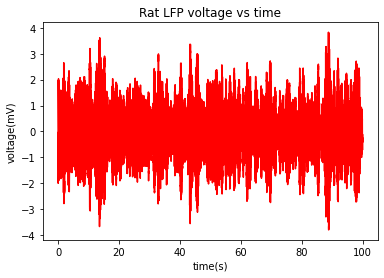

In [14]:
# Plot your LFP data!
plt.plot(time, rat_cfc_reshaped, color = "red")
ax = plt.xlabel('time(s)')
ax = plt.ylabel('voltage(mV)')
ax = plt.title('Rat LFP voltage vs time')

It's hard to see anything with so much data, so let's zoom in on just a 1 s. interval:

Text(0, 0.5, 'Voltage [mV]')

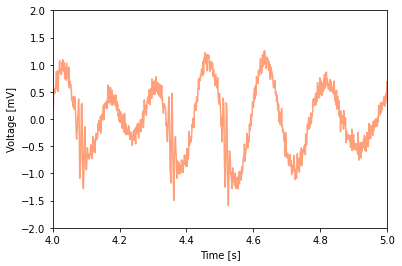

In [19]:
plt.plot(time, rat_cfc_reshaped, color= 'lightsalmon')            # Plot the LFP data,
plt.xlim([4, 5])            # ... restrict the x-axis to a 1 s interval,
plt.ylim([-2, 2])           # ... and tighten the y-axis.
plt.xlabel('Time [s]')      # Label the axes
plt.ylabel('Voltage [mV]')

Question: What do you notice about the data? What is the dominant oscillation? What about other oscillations? Any relationship between the two?

Something happening at the phase of the troughs to modify the amplitude (amplitude gets bigger at various phases). The place where this gets modified is the same every time. Nestled within the 6Hz oscilliation is a bunch of higher freq oscillations, and sometimes the amplitude increases--> the place where this happens is consistent in each cycle (around the trough). Could be due to pyramidal neurons that surround excitatory neurons in the hippocampus (slower are interneuron to interneuron-- faster are interneurons talking to them??)

##Spectral Analysis

Visual inspection of the LFP data suggests that multiple rhythms appear. To further characterize this observation, we compute the spectrum of the LFP data. We analyze the entire 100 s of data and compute the spectrum with a Hanning taper.

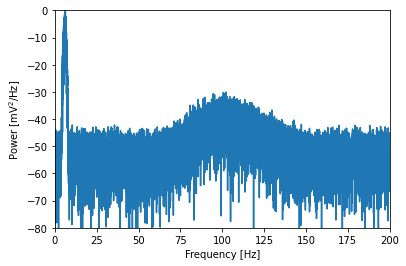

In [20]:
dt = time[1] - time[0]                # Define the sampling interval,
T = time[-1]                       # ... the duration of the data,
N = len(rat_cfc_reshaped)                    # ... and the no. of data points

x = np.hanning(N) * rat_cfc_reshaped            # Multiply data by a Hanning taper
xf = np.fft.rfft(x - x.mean())         # Compute Fourier transform
Sxx = 2*dt**2/T * (xf*np.conj(xf)) # Compute the spectrum
Sxx = np.real(Sxx)                 # Ignore complex components

df = 1 / T                      # Define frequency resolution,
fNQ = 1 / dt / 2                # ... and Nyquist frequency. 

faxis = np.arange(0, fNQ + df, df) # Construct freq. axis
plt.plot(faxis, 10 * np.log10(Sxx))    # Plot spectrum vs freq.
plt.xlim([0, 200])                  # Set freq. range, 
plt.ylim([-80, 0])                  # ... and decibel range
plt.xlabel('Frequency [Hz]')        # Label the axes
plt.ylabel('Power [mV$^2$/Hz]');

#two dominant frequency bands in the signal

The resulting spectrum reveals two intervals of increased power spectral density. The lowest-frequency peak at 6 Hz is also the largest and corresponds to the slow rhythm we observe dominating the signal through visual inspection. Remember a plot of that signal: At higher frequencies, we find an additional broadband peak at approximately 80–120 Hz. These spectral results support our initial visual inspection of the signal; there exist both low- and high-frequency activities in the LFP data. We now consider the primary question of interest: Do these different frequency rhythms exhibit associations?


##Phase-Amplitude Coupling

To assess whether different frequency rhythms interact in the LFP recording, we implement a measure to calculate the CFC. The idea of CFC analysis, in our case, is to determine whether a relation exists between the phase of a low-frequency signal and the envelope or amplitude of a high-frequency signal. In general, computing CFC involves three steps. Each step contains important questions and encompasses entire fields of study. Our goal in this section is to move quickly forward and produce a procedure we can employ, investigate, and criticize. Continued study of CFC - and the associated nuances of each step - is an active area of ongoing [research]('https://pubmed.ncbi.nlm.nih.gov/26549886/').

##CFC Analysis Steps

- Filter the data into high- and low-frequency bands.

- Extract the amplitude and phase from the filtered signals.

- Determine if the phase and amplitude are related.

The first step in the CFC analysis is to filter the data into two frequency bands of interest. The choice is not arbitrary: the separate frequency bands are motivated by initial spectral analysis of the LFP data. In this case, we choose the low-frequency band as 5–7 Hz, consistent with the largest peak in the spectrum, and the high-frequency band as 80–120 Hz, consistent with the second-largest broadband peak. To consider alternative frequency bands, the same analysis steps would apply.

There are many options to perform the filtering. To do so requires us to design a filter that ideally extracts the frequency bands of interest without distorting the results. Here, we apply a finite impulse response (FIR) filter. We start by extracting the low-frequency band:

In [21]:
from scipy import signal
Wn = [5,7];                         # Set the passband [5-7] Hz,
n = 100;                            # ... and filter order,
                                    # ... build the bandpass filter,
b = signal.firwin(n, Wn, fs=fNQ, pass_zero=False, window='hamming');
Vlo = signal.filtfilt(b, 1, rat_cfc_reshaped);

Next, we extract the high-frequency band:

In [22]:
Wn = [80, 120];                     # Set the passband [80-120] Hz,
n = 100;                            # ... and filter order,
                                    # ... build the bandpass filter,
b = signal.firwin(n, Wn, fs=fNQ, pass_zero=False, window='hamming');
Vhi = signal.filtfilt(b, 1, rat_cfc_reshaped);   # ... and apply it to the data.

For each frequency band, we specify a frequency interval of interest by defining the low- and high-cutoff frequencies in the variable `Wn`. In this way, we specify the passband of the filter. We then set the filter order (`n`) and design the filter using the Python function `signal.firwin` from the SciPy package. Finally, we apply the filter using the Python function `signal.filtfilt`, which performs zero-phase filtering by applying the filter in both the forward and reverse directions. We note that, in this case, the filtering procedure is nearly the same in both frequency bands; the only change is the specification of the frequency interval of interest.

To understand the impact of this filtering operation on the LFP, let’s plot the results. More specifically, let’s plot the original signal, and the signal filtered in the low- and high-frequency bands, for an example 2 s interval of time:

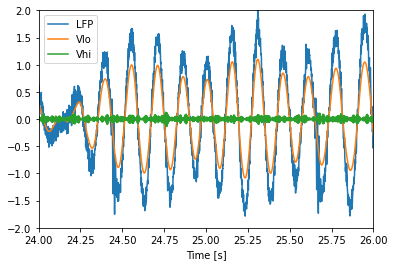

In [23]:
plt.plot(time, rat_cfc_reshaped)                    # Plot the original data vs time.
plt.plot(time, Vlo)                    # Plot the low-frequency filtered data vs time.
plt.plot(time, Vhi)                    # Plot the high-frequency filtered data vs time.
plt.xlabel('Time [s]')
plt.xlim([24, 26]);                 # Choose a 2 s interval to examine
plt.ylim([-2, 2]);
plt.legend(['LFP', 'Vlo', 'Vhi']);  # Add a legend.

As expected, the low-frequency band (orange) captures the large-amplitude rhythm dominating the LFP signal, while the higher-frequency band (green) isolates the brief bursts of faster activity.


The next step in the CFC procedure is to extract the phase of the low-frequency signal and the amplitude envelope (or simply, amplitude) of the high-frequency signal. To compute a particular type of CFC, namely phase-amplitude coupling, we then compare these two signals, i.e., we compare the phase of the low-frequency activity and the amplitude envelope of the high-frequency activity. How do we actually extract the phase and amplitude signals from the data? There are a variety of options to do so, and we choose here to employ the analytic signal approach, which allows us to estimate the instantaneous phase and amplitude envelope of the LFP.

The first step in computing the analytic signal is to compute the Hilbert transform. We begin with some notation. Define 𝑥
 as a narrowband signal (i.e., a signal with most of its energy concentrated in a narrow frequency range note, e.g., the low- or high-frequency band filtered signals we’ve created). Then the Hilbert transform of 𝑥
, let’s call it 𝑦
, is

𝑦=𝐻(𝑥).


It’s relatively easy to compute the analytic signal and extract the phase and amplitude in Python:

In [24]:
phi = np.angle(signal.hilbert(Vlo))  # Compute phase of low-freq signal
amp = abs(signal.hilbert(Vhi))       # Compute amplitude of high-freq signal

Question: Why do we use the <code>abs</code> function (absolute value) to return the amplitude of our high-frequency signal?

As with the previous steps, we have at our disposal a variety of procedures to assess the relation between the phase (of the low-frequency signal) and amplitude (of the high-frequency signal). We do so here in one way, by computing the phase-amplitude plot.

##The phase-amplitude plot

To start, define the two-column phase-amplitude vector, where 𝜙(𝑖)
 is the phase of the low-frequency band activity at time index 𝑖
, and 𝐴(𝑖)
 is the amplitude of the high-frequency band activity at time index 𝑖
. In other words, each row defines the instantaneous phase and amplitude of the low- and high-frequency filtered data, respectively.

We now use this two-column vector to assess whether the phase and amplitude envelope are related. Let’s begin by plotting the average amplitude versus phase. We divide the phase interval into bins of size 0.1 beginning at −𝜋
 and ending at 𝜋.
 the choice of bin size is somewhat arbitrary; this choice will work fine, but you might consider the impact of other choices.

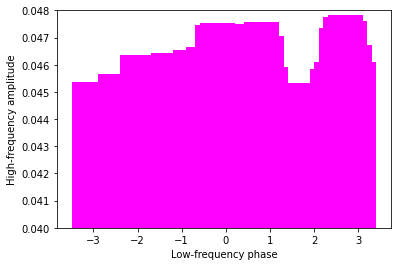

In [29]:
p_bins = np.arange(-np.pi, np.pi, 0.1)
a_mean = np.zeros(np.size(p_bins)-1)
p_mean = np.zeros(np.size(p_bins)-1)
for k in range(np.size(p_bins)-1):     #For each phase bin,
    pL = p_bins[k]                  #... lower phase limit,
    pR = p_bins[k+1]                #... upper phase limit.
    indices=(phi>=pL) & (phi<pR)    #Find phases falling in bin,
    a_mean[k] = np.mean(amp[indices])  #... compute mean amplitude,
    p_mean[k] = np.mean([pL, pR])      #... save center phase.
plt.bar(p_mean, a_mean, color = "magenta")                #Plot the phase versus amplitude,
plt.ylim([.04, .048])
plt.ylabel('High-frequency amplitude')  #... with axes labeled.
plt.xlabel('Low-frequency phase');
#average amplitude across cycles-- in radians

Question: Consider this plot of the average amplitude versus phase. Does this result suggest CFC occurs in these data? If there were no CFC occurring in the data, what would you expect this plot to look like?

><b>Task:</b> Re-make the above graph as a bar graph instead of a line plot.

As a basic statistic to capture the extent of this relation, we compute the difference between the maximum and minimum of the average amplitude envelope over phases. Let’s assign this difference the label ℎ
. In Python,

In [30]:
h = max(a_mean)-min(a_mean)
print(h)

0.003491200737105307


This value, on its own, is difficult to interpret. Is it bigger or smaller than we expect? To assess the significance of ℎ
, let’s generate a surrogate phase-amplitude vector by resampling without replacement the amplitude time series (i.e., the second column of the phase-amplitude vector). By performing this resampling, we reassign each phase an amplitude chosen randomly from the entire 100 s LFP recording. We expect that if CFC does exist in these data, then the timing of the phase and amplitude vectors will be important; for CFC to occur, the amplitude and phase must coordinate in time. By disrupting this timing in the resampling procedure, we expect to eliminate the coordination between amplitude and phase necessary to produce CFC.

For each surrogate phase-amplitude vector, we compute the statistic ℎ
. To generate a distribution of ℎ
 values, let’s repeat 1,000 times this process of creating surrogate data through resampling and computing ℎ
.

In [35]:
n_surrogates = 1000;                    #Define no. of surrogates.
hS = np.zeros(n_surrogates)                #Vector to hold h results.
for ns in range(n_surrogates):          #For each surrogate,
    ampS = amp[np.random.randint(0,N,N)]          #Resample amplitude,
    p_bins = np.arange(-np.pi, np.pi, 0.1)       #Define the phase bins
    a_mean = np.zeros(np.size(p_bins)-1)      #Vector for average amps.
    p_mean = np.zeros(np.size(p_bins)-1)      #Vector for phase bins.
    for k in range(np.size(p_bins)-1):
        pL = p_bins[k]                  #... lower phase limit,
        pR = p_bins[k+1]                #... upper phase limit.
        indices=(phi>=pL) & (phi<pR)    #Find phases falling in bin,
        a_mean[k] = np.mean(ampS[indices]) #... compute mean amplitude,
        p_mean[k] = np.mean([pL, pR])      #... save center phase.
    hS[ns] = max(a_mean)-min(a_mean)    # Store surrogate h.

In this code, we first define the number of surrogates (variable `n_surrogates`) and a vector to store the statistic ℎ
 computed for each surrogate phase-amplitude vector (variable `hS`). Then, for each surrogate, we use the Python function `randint` to randomly permute the amplitude vector without replacement. We then use this permuted amplitude vector (variable `ampS`) and the original phase vector (variable `phi`) to compute ℎ
; this last step utilizes the Python code developed earlier to compute `h` for the original (unpermuted) data.

Let’s now view the results of this resampling procedure by creating a histogram of the variable `hS`, and compare this distribution to the value of `h` we computed earlier.

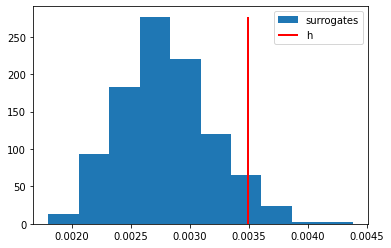

In [36]:
counts, _, _ = plt.hist(hS, label='surrogates')               # Plot the histogram of hS, and save the bin counts.
plt.vlines(h, 0, max(counts), colors='red', label='h', lw=2)  # Plot the observed h,
plt.legend();  

The value of ℎ
 computed from the original data (`h`) lies far outside the distribution of surrogate ℎ
 values (`hS`). To compute a 𝑝
-value, we determine the proportion of surrogate ℎ
 values greater than the observed ℎ
 value:

In [37]:
p = sum([s > h for s in hS]) / len(hS)
print(p)

0.047


We find a 𝑝
-value that is very small; there are no surrogate values of ℎ
 that exceed the observed value of ℎ
. We therefore conclude that in this case the observed value of ℎ
 is significant. As a statistician would say, we reject the null hypothesis of no CFC between the phase of the 5-7 Hz low-frequency band and the amplitude of the 80-120 Hz high frequency band.